# `VC` Práctica 3. Redes neuronales convolucionales (Parte 2: apartado 3)

> Alumno: Miguel Ángel Fernández Gutiérrez
>
> Correo: [mianfg@correo.ugr.es](mailto:mianfg@correo.ugr.es)
> 
> Grupo: VC1

In [ ]:
# PATHS
PATH_CONTENT = './'

In [ ]:
import os
get_route = lambda route: os.path.join('./', route)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%matplotlib inline

# Generales
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Keras
import keras.utils.np_utils as np_utils

# Tensorflow
#from tensorflow import logging

# Modelos y capas
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers import BatchNormalization
from keras import Model, Input

# Optimizador
from tensorflow.keras.optimizers import SGD, Adam

# Función de pérdida
from keras.losses import categorical_crossentropy

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

# Conjunto de datos y preprocesamiento
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator

# ResNet
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

En el siguiente bloque de código, aparecen funciones auxiliares que serán usadas en esta práctica. Muchas de ellas usan el código proporcionado por los profesores de la asignatura.

In [ ]:
def _calcular_accuracy(labels, preds):
    labels = np.argmax(labels, axis = 1)
    preds = np.argmax(preds, axis = 1)
    
    accuracy = sum(labels == preds)/len(labels)
    
    return accuracy

def _mostrar_evolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(loss)
    ax1.plot(val_loss)
    ax1.legend(['Training', 'Validation'])
    ax1.title.set_text('Loss')

    ax2.plot(acc)
    ax2.plot(val_acc)
    ax2.legend(['Training', 'Validation'])
    ax2.title.set_text('Accuracy')

    plt.show()

def _mostrar_evoluciones(hist_dict):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.title.set_text('Loss')
    ax2.title.set_text('Accuracy')
    color = plt.cm.rainbow(np.linspace(0, 1, len(hist_dict.keys())))

    for h in hist_dict.keys():
        ax1.plot(hist_dict[h].history['loss'], linestyle='dashed', c=color[h])
        ax1.plot(hist_dict[h].history['val_loss'], c=color[h])
        ax2.plot(hist_dict[h].history['acc'], linestyle='dashed', c=color[h])
        ax2.plot(hist_dict[h].history['val_loss'], c=color[h])


def _leer_imagenes(vec_imagenes, path):
    clases = np.array([img.split('/')[0] for img in vec_imagenes])
    imagenes = np.array([img_to_array(load_img(path + "/" + img, target_size = (224, 224))) 
                           for img in vec_imagenes])
    return imagenes, clases
    
def _cargar_dataset(name, n_classes=25):
    if name == 'cifar100':
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')
        x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
        # normalización
        x_train /= 255
        x_test /= 255

        # tomamos las primeras `n_classes` clases
        train_idx = np.isin(y_train, np.arange(n_classes))
        train_idx = np.reshape(train_idx, -1)
        x_train = x_train[train_idx]
        y_train = y_train[train_idx]

        test_idx = np.isin(y_test, np.arange(n_classes))
        test_idx = np.reshape(test_idx, -1)
        x_test = x_test[test_idx]
        y_test = y_test[test_idx]

        # Convertimos los vectores de clases en matrices binarias
        y_train = np_utils.to_categorical(y_train, n_classes)
        y_test = np_utils.to_categorical(y_test, n_classes)

        return x_train, y_train, x_test, y_test
    elif name == 'ucsd':
        path = PATH_CONTENT

        # Cargamos los ficheros
        train_images = np.loadtxt(path + "/train.txt", dtype = str)
        test_images = np.loadtxt(path + "/test.txt", dtype = str)
        
        # Leemos las imágenes con la función anterior
        print("Cargando imágenes de train...", end='')
        train, train_clases = _leer_imagenes(train_images, path + '/images')
        print("\rCargando imágenes de test...", end='')
        test, test_clases = _leer_imagenes(test_images, path + '/images')

        print("\rImágenes cargadas satisfactoriamente")
        
        # Pasamos los vectores de las clases a matrices 
        # Para ello, primero pasamos las clases a números enteros
        clases_posibles = np.unique(np.copy(train_clases))
        for i in range(len(clases_posibles)):
            train_clases[train_clases == clases_posibles[i]] = i
            test_clases[test_clases == clases_posibles[i]] = i

        # Después, usamos la función to_categorical()
        train_clases = np_utils.to_categorical(train_clases, 200)
        test_clases = np_utils.to_categorical(test_clases, 200)
        
        # Barajar los datos
        train_perm = np.random.permutation(len(train))
        train = train[train_perm]
        train_clases = train_clases[train_perm]

        test_perm = np.random.permutation(len(test))
        test = test[test_perm]
        test_clases = test_clases[test_perm]
        
        return train, train_clases, test, test_clases
    else:
        raise ValueError('No se ha insertado un nombre de dataset permitido')

def _evaluate(model, x_test, y_test):
    return model.model.evaluate(x_test, y_test, verbose=1)

def _print_evaluate(model, evaluate_results, message=None):
    print(f"Estadísticas de {model.name}" + (f" ({message})" if message else "") + ":")
    print(f" - Test loss: {evaluate_results[0]}")
    print(f" - Test accuracy: {evaluate_results[1]}")

- - -

### Apartado 3. **Transferencia de modelos y ajuste fino con ResNet50 para la base de datos Caltech-UCSD**

#### Conjunto de datos

En este apartado trabajaremos con el conjunto de datos Caltech-UCSD. Este
conjunto de datos se compone de 6033 imágenes de 200 especies de pájaros. 

Tiene, por tanto, 200 clases, con 3000 imágenes en el conjunto de
entrenamiento y 3033 en el de prueba. De nuevo, se dejará un 10% del conjunto
de entrenamiento para validación. Para leer el conjunto de datos usar las
funciones dadas.

Usaremos el modelo de red ResNet50 ya pre-entrenada con ImageNet y que
está disponible en Keras. Se pide,

1. Usar ResNet50 como un extractor de características para los datos de
Caltech-UCSD disponible [aquí](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html). Para ello eliminaremos al menos las dos últimas capas del modelo descargado, añadiremos algunas capas de cálculo adicional y la capa de salida.
En concreto realizar los siguientes experimentos:

  A.a) Adaptar el modelo ResNet50 entrenado con ImageNet a los datos de
Caltech-UCSD y estimar su desempeño con estos datos.
  
  A.b) Eliminar las capas
finales FC y la salida, substituirlas por nuevas FC y salida y reentrenarlas con
Caltech-UCSD.

  A.c) Comparar resultados con el modelo anterior en el que
unicamente se cambia y reentrena la capa de salida

  B) Eliminar las capas de salida, FC y AveragePooling. En este momento
tendrá un extractor de características. Añada nuevas capas que mezclen dichas
características y den una clasificación. Entrene la red resultante y compare sus
resultados con los resultados del punto A.

2. Realizar un ajuste fino de toda la red ResNet50, al conjunto de datos.
Caltech-UCSD. Recordar que el número de épocas a ejecutar debe ser pequeño.

La red ResNet50 pre-entrenada con ImageNet se puede descargar del
repositorio de modelos de Keras.

##### Solución propuesta

Comenzaremos con el _transfer learning_. De acuerdo a la [documentación de Keras](https://keras.io/guides/transfer_learning), el _transfer learning_ consiste en tomar las características aprendidas de un problema y usarlas en un problema similar. La idea, por tanto, es usar los pesos aprendidos de un problema enterior para reentrenar un nuevo modelo.

En nuestro caso, haremos lo siguiente:

1. Instanciaremos el modelo base de `ResNet50`, con los pesos de ImageNet y sin la última capa FC (para clasificación, que no necesitamos).
2. Ejecutaremos `predict` sobre nuestros datos. Esta fase se llama **extracción de características**.
3. Pasaremos esos datos a un nuevo modelo. Usaremos dos alternativas:
  * Para el **punto 1.A**, el modelo `FC` constará únicamente en una capa `Dense` para clasificación (_softmax_),
  * mientras que para el **punto 1.B** el modelo `Conv` consistirá en algunas capas de convolución.

  Para poder usar el _output_ de `ResNet50` como _input_ para ambos modelos, deberemos cambiar el parámetro `pooling` (ver comentarios en el código).

Existe otra posibilidad, que sería crear un modelo que integrase `ResNet50` con `freeze=True`. Sin embargo, el tiempo de ejecución es considerablemente mayor.

> **Sobre la estructura de archivos.** Dado que en el enunciado de la práctica no se especifica una estructura concreta para los archivos, se especifica a continuación la estructura que se sigue. De todos modos, se obedece el punto 5 en el que se concreta que todos los ficheros deben estar en una carpeta `imagenes`.

Antes de nada, deberemos extraer los datos de Drive al sistema de archivos de Colab. Por favor, antes de ejecutar el código asegúrese de que la estructura de archivos en Google Drive es la siguiente:

```
.
└── Colab Notebooks
    └── imagenes
        ├── images.zip    (images.tgz pasado a zip)
        ├── train.txt     (archivo contenido en lists.tgz)
        └── test.txt      (archivo contenido en lists.tgz)
```

> * El archivo `images.tgz` ha sido obtenido desde [aquí](http://www.vision.caltech.edu/visipedia-data/CUB-200/images.tgz).
> * El archivo `lists.tgz` ha sido obtenido desde [aquí](http://www.vision.caltech.edu/visipedia-data/CUB-200/lists.tgz).

In [ ]:
!rm -rf "./images"
!cp "./images/train.txt"
!cp "./images/test.txt"
!unzip -q "./images.zip" -d "."

A continuación, crearemos:

* Los modelos `FC` y `Conv` explicados anteriormente (con el prefijo `ResNet50_`).
* Una nueva función de _transfer learning_ para ResNet50, `train_resnet_transfer`, que ejecutará el proceso descrito.

Más adelante hablaremos individualmente de cada apartado.

In [ ]:
class CNNModel:
    pass

class ResNet50_FC(CNNModel):
    """ Modelo ResNet50_FC
    """
    def __init__(self):
        self.model = Sequential()
        self.model.add(Dense(200, activation='softmax', input_shape=(2048,)))

        self.name = 'ResNet50_FC'

class ResNet50_Conv(CNNModel):
    """ Modelo ResNet50_Conv
    """
    def __init__(self):
        self.model = Sequential()
        self.model.add(Conv2D(64, kernel_size=(3,3), use_bias=False, activation='relu', input_shape=(7,7,2048)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.4))
        self.model.add(Flatten())
        self.model.add(Dense(512, activation='relu', use_bias=False))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        self.model.add(Dense(200, activation='softmax'))

        self.name = 'ResNet50_Conv'

In [ ]:
fdefault_optimizer = SGD(learning_rate=1e-2, decay=1e-6, momentum=9e-1, nesterov=True)

# based on: https://keras.io/guides/transfer_learning/
def train_resnet_transfer(model, x_train, y_train, x_test, y_test, batch_size, n_epochs,
          optimizer=default_optimizer,
          loss='categorical_crossentropy',
          metrics=['acc'],
          split=.1):
    """Entrenar desde ResNet50 con transfer learning

    Args:
        model (ResNet50_FC|ResNet50_Conv): Modelo de CNN secuencial
        batch_size (number): Tamaño del batch
        n_epochs (number): Número de épocas

    Returns:
        [type]: [description]
    """
    # generadores de entrenamiento y test
    datagen_train = ImageDataGenerator(preprocessing_function=preprocess_input)
    datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

    # formato de salida de ResNet50
    if model.name == 'ResNet50_Conv':
        pooling_type = None     # salida: tensor 7 x 8 x 2048
    elif model.name == 'ResNet50_FC':
        pooling_type = 'avg'    # salida: vector de 2048 entradas
    else:
        raise ValueError(f'train_resnet_transfer sólo puede entrenarse con los modelos ResNet50_FC y ResNet50_Conv, obtenido {model.name}')

    resnet = ResNet50(
        weights = 'imagenet',       # usar los pesos de ImageNet
        include_top = False,        # no incluir la capa FC en el top del modelo
        pooling = pooling_type,     # optional pooling mode for feature extraction when include_top is False
        input_shape = (224, 224, 3)
    )

    # extracción de características
    print("Ejecutando ResNet50...")
    resnet_features = {}
    resnet_features_train = resnet.predict(
        x = datagen_train.flow(x_train, batch_size=1, shuffle=False),
        verbose = 1,
        steps = len(x_train)
    )
    resnet_features_test = resnet.predict(
        x = datagen_test.flow(x_test, batch_size=1, shuffle=False),
        verbose = 1,
        steps = len(x_test)
    )

    print(f"Ejecutando modelo {model.name}...")
    # ejecutamos el modelo
    model.model.compile(
        loss = loss,
        optimizer = optimizer,
        metrics = metrics
    )

    hist = model.model.fit(resnet_features_train, y_train, batch_size, n_epochs, verbose=1, validation_split=split)
    scores = model.model.evaluate(resnet_features_test, y_test, verbose=0)

    return hist, scores

In [ ]:
_m3, _h3, _s3, _r3 = {}, {}, {}, {}

Para el **punto 1.A** vamos a usar el _output_ de ResNet50 y lo pasaremos a una única capa `Dense`, obteniendo un clasificador.

In [ ]:
_m3[0] = ResNet50_FC()
print("Resumen de ResNet50_FC")
print("----------------------")
_m3[0].model.summary()

Resumen de ResNet50_FC
----------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 200)               409800    
                                                                 
Total params: 409,800
Trainable params: 409,800
Non-trainable params: 0
_________________________________________________________________


Imágenes cargadas satisfactoriamente
Ejecutando ResNet50...
3033/3033 [==============================] - 59s 20ms/step
Ejecutando modelo ResNet50_FC...
Epoch 1/10
85/85 [==============================] - 1s 8ms/step - loss: 4.3688 - acc: 0.1352 - val_loss: 3.1851 - val_acc: 0.2667
Epoch 2/10
85/85 [==============================] - 0s 4ms/step - loss: 1.6306 - acc: 0.6148 - val_loss: 2.5038 - val_acc: 0.3967
Epoch 3/10
85/85 [==============================] - 0s 5ms/step - loss: 0.8210 - acc: 0.8370 - val_loss: 2.3002 - val_acc: 0.4333
Epoch 4/10
85/85 [==============================] - 0s 4ms/step - loss: 0.4774 - acc: 0.9304 - val_loss: 2.1072 - val_acc: 0.4900
Epoch 5/10
85/85 [==============================] - 0s 4ms/step - loss: 0.3090 - acc: 0.9737 - val_loss: 2.0139 - val_acc: 0.4900
Epoch 6/10
85/85 [==============================] - 0s 5ms/step - loss: 0.2179 - acc: 0.9881 - val_loss: 1.9994 - val_acc: 0.4967
Epoch 7/10
85/85 [==============================] - 0s 5ms/step - lo

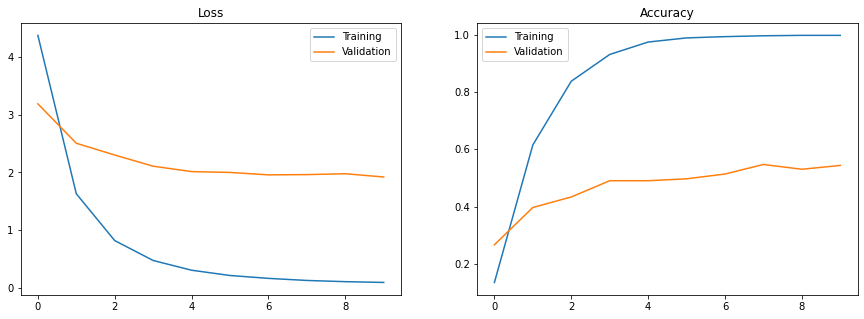

Estadísticas de ResNet50_FC:
 - Test loss: 2.3515419960021973
 - Test accuracy: 0.4342235326766968


In [ ]:
_h3[0], _s3[0] = train_resnet_transfer(_m3[0], *_cargar_dataset('ucsd'), batch_size=32, n_epochs=10)
_mostrar_evolucion(_h3[0])
_print_evaluate(_m3[0], _s3[0])

In [ ]:
_m3[1] = ResNet50_Conv()
print("Resumen de ResNet50_Conv")
print("------------------------")
_m3[1].model.summary()

Resumen de ResNet50_Conv
------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          1179648   
                                                                 
 batch_normalization_4 (Batc  (None, 5, 5, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               819200    
                                                                 
 batch_normalization_5 (Batc  (None, 512)              2048      
 hNo

Imágenes cargadas satisfactoriamente
Ejecutando ResNet50...
3033/3033 [==============================] - 60s 20ms/step
Ejecutando modelo ResNet50_Conv...
Epoch 1/10
85/85 [==============================] - 4s 25ms/step - loss: 5.6114 - acc: 0.0296 - val_loss: 5.3187 - val_acc: 0.0900
Epoch 2/10
85/85 [==============================] - 2s 18ms/step - loss: 3.7948 - acc: 0.1604 - val_loss: 3.3805 - val_acc: 0.1933
Epoch 3/10
85/85 [==============================] - 2s 18ms/step - loss: 2.6900 - acc: 0.3411 - val_loss: 2.9834 - val_acc: 0.3100
Epoch 4/10
85/85 [==============================] - 1s 17ms/step - loss: 1.9730 - acc: 0.4674 - val_loss: 2.7754 - val_acc: 0.3100
Epoch 5/10
85/85 [==============================] - 2s 18ms/step - loss: 1.4695 - acc: 0.5896 - val_loss: 2.6012 - val_acc: 0.3467
Epoch 6/10
85/85 [==============================] - 1s 17ms/step - loss: 1.0943 - acc: 0.6937 - val_loss: 2.4556 - val_acc: 0.3633
Epoch 7/10
85/85 [==============================] - 1s 17ms/

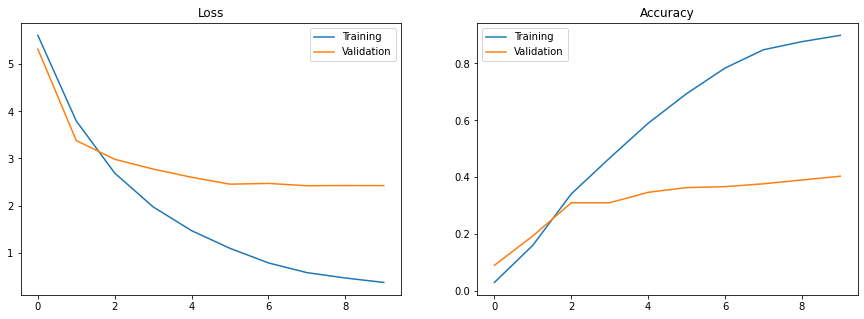

Estadísticas de ResNet50_Conv:
 - Test loss: 2.7985329627990723
 - Test accuracy: 0.3577316105365753


In [ ]:
_h3[1], _s3[1] = train_resnet_transfer(_m3[1], *_cargar_dataset('ucsd'), batch_size=32, n_epochs=10)
_mostrar_evolucion(_h3[1])
_print_evaluate(_m3[1], _s3[1])

In [ ]:
default_optimizer = SGD(learning_rate=1e-2, decay=1e-6, momentum=9e-1, nesterov=True)

class ResNet50_FineTuning(CNNModel):
    def __init__(self):
        resnet = ResNet50(
            weights = 'imagenet',       # usar los pesos de ImageNet
            include_top = False,        # no incluir la capa FC en el top del modelo
            pooling = 'avg',     # optional pooling mode for feature extraction when include_top is False
            input_shape = (224, 224, 3)
        )
        x = Dense(512, activation='relu')(resnet.output)
        x = Dropout(0.4)(x)
        out = Dense(200, activation='softmax')(x)

        self.model = Model(inputs=resnet.input, outputs=out)

        self.name = 'ResNet50_FineTuning'

def train_resnet_fine(model, x_train, y_train, x_test, y_test, batch_size, n_epochs,
          optimizer=default_optimizer,
          loss='categorical_crossentropy',
          metrics=['acc'],
          split=.1):
    """Entrenar desde ResNet50 con transfer learning

    Args:
        model (ResNet50_FC|ResNet50_Conv): Modelo de CNN secuencial
        batch_size (number): Tamaño del batch
        n_epochs (number): Número de épocas

    Returns:
        [type]: [description]
    """
    if model.name != 'ResNet50_FineTuning':
        raise ValueError(f'train_resnet_fine sólo acepta el modelo ResNet50_FineTuning, se le pasó {model.name}')
    # generadores de entrenamiento y test
    datagen_train = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=split)
    x_test_pre = preprocess_input(x_test)

    # ejecutamos el modelo
    model.model.compile(
        loss = loss,
        optimizer = optimizer,
        metrics = metrics
    )

    training = datagen_train.flow(
        x_train,
        y_train,
        batch_size = batch_size,
        subset = 'training'
    )
    validation = datagen_train.flow(
        x_train,
        y_train,
        batch_size = batch_size,
        subset = 'validation'
    )

    hist = model.model.fit(
        x = training, 
        steps_per_epoch = len(x_train)*(1-split)/batch_size,
        epochs = n_epochs,
        validation_data = validation,
        validation_steps = len(x_train)*split/batch_size
    )
    scores = model.model.evaluate(x_test_pre, y_test, verbose=0)

    return hist, scores

In [ ]:
_m3[2] = ResNet50_FineTuning()
print("Resumen de ResNet50_FineTuning")
print("------------------------------")
_m3[2].model.summary()

Resumen de ResNet50_FineTuning
------------------------------
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                              

In [ ]:
_h3[2], _s3[2] = train_resnet_fine(_m3[2], *_cargar_dataset('ucsd'), batch_size=32, n_epochs=10)
_mostrar_evolucion(_h3[2])
_print_evaluate(_m3[2], _s3[2])

Imágenes cargadas satisfactoriamente
Epoch 1/10
84/84 [==============================] - 71s 758ms/step - loss: 5.0510 - acc: 0.0426 - val_loss: 4.9914 - val_acc: 0.0500
Epoch 2/10
84/84 [==============================] - 63s 741ms/step - loss: 3.5382 - acc: 0.2015 - val_loss: 5.0361 - val_acc: 0.0833
Epoch 3/10
84/84 [==============================] - 63s 741ms/step - loss: 2.3761 - acc: 0.3985 - val_loss: 4.2949 - val_acc: 0.1833
Epoch 4/10
84/84 [==============================] - 63s 743ms/step - loss: 1.5627 - acc: 0.5852 - val_loss: 4.1366 - val_acc: 0.1800
Epoch 5/10
84/84 [==============================] - 62s 740ms/step - loss: 1.0867 - acc: 0.7044 - val_loss: 3.3930 - val_acc: 0.2700
Epoch 6/10
84/84 [==============================] - 62s 741ms/step - loss: 0.7195 - acc: 0.7900 - val_loss: 3.7124 - val_acc: 0.2733
Epoch 7/10
84/84 [==============================] - 63s 741ms/step - loss: 0.5199 - acc: 0.8452 - val_loss: 3.8277 - val_acc: 0.2933
Epoch 8/10
84/84 [==============